# 《动手深度学习》Pytorch版 第1部分深度学习基础
## 1.0 线性回归从零开始
本节将介绍如何只利用**<font color='orange'>Tensor</font>**和**<font color='orange'>autograd</font>**来实现一个线性回归的训练。

In [1]:
%matplotlib inline
import torch
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random

### 1.0.0 生成数据集
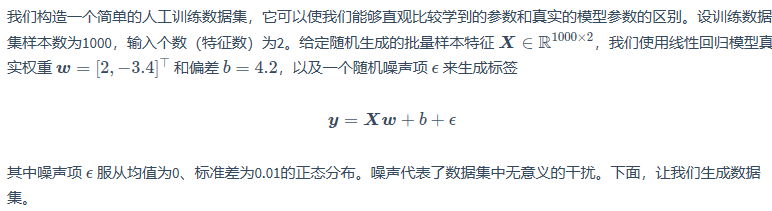

In [7]:
num_inputs = 2
num_examples = 1000
true_w = torch.tensor([[2, -3.4]]).T
true_b = 4.2
features = torch.randn(num_examples, num_inputs,
                       dtype=torch.float32)
labels = torch.mm(features,true_w) + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()),
                       dtype=torch.float32)

通过生成第二个特征features[:, 1]和标签 labels 的散点图，可以更直观地观察两者间的线性关系。

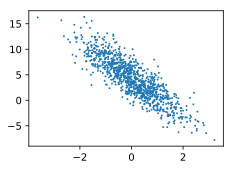

In [9]:
def use_svg_display():
    # 用矢量图显示
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize

# # 在../d2lzh_pytorch里面添加上面两个函数后就可以这样导入
# import sys
# sys.path.append("..")
# from d2lzh_pytorch import * 

set_figsize()
plt.scatter(features[:, 1].numpy(), labels.numpy(), 1);

### 1.0.1 读取数据
在训练模型的时候，我们需要遍历数据集并不断读取小批量数据样本。这里我们定义一个函数：它每次返回<font color='orange'>batch_size（批量大小）</font>个随机样本的特征和标签。

In [10]:
# 本函数已保存在d2lzh包中方便以后使用
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  # 样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)]) # 最后一次可能不足一个batch
        yield  features.index_select(0, j), labels.index_select(0, j)

In [11]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, y)
    break

tensor([[ 0.6652, -1.1193],
        [ 0.0108, -0.1219],
        [ 0.7143,  1.0045],
        [-0.1666,  0.3335],
        [-0.9676,  1.2212],
        [-1.2315,  1.0858],
        [ 1.5532,  0.1369],
        [-1.3392, -0.0990],
        [-0.4312, -0.5164],
        [ 1.5827,  0.3067]]) tensor([[ 9.3328],
        [ 4.6409],
        [ 2.2107],
        [ 2.7537],
        [-1.8869],
        [-1.9485],
        [ 6.8387],
        [ 1.8646],
        [ 5.0742],
        [ 6.3302]])


### 1.0.2 初始化模型参数
我们将权重初始化成均值为0、标准差为0.01的正态随机数，偏差则初始化成0。

In [12]:
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float32)
b = torch.zeros(1, dtype=torch.float32)

之后的模型训练中，需要对这些参数求梯度来迭代参数的值，因此我们要让它们的<font color='orange'>requires_grad=True</font>。

In [13]:
w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True) 

tensor([0.], requires_grad=True)

In [23]:
#可以在初始化参数时就设置w的requires_grad为True
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float32,requires_grad=True)

### 1.0.3 定义模型
下面是线性回归的矢量计算表达式的实现。我们使用mm函数做矩阵乘法。

In [24]:
def linreg(X,w,b):
    return torch.mm(X,w) + b

### 1.0.4 定义损失函数
下面是线性回归的矢量计算表达式的实现。我们使用<font color='orange'>mm</font>函数做矩阵乘法。

In [25]:
def squared_loss(y_hat,y):
    return (y_hat-y.view(y_hat.shape))**2/2

### 1.0.5 定义优化算法

In [26]:
def sgd(params, lr, batch_size):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    for param in params:
        param.data -= lr * param.grad / batch_size # 注意这里更改param时用的param.data

### 1.0.6 训练模型

In [ ]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):  # 训练模型一共需要num_epochs个迭代周期
    # 在每一个迭代周期中，会使用训练数据集中所有样本一次（假设样本数能够被批量大小整除）。X
    # 和y分别是小批量样本的特征和标签
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y).sum()  # l是有关小批量X和y的损失
        l.backward()  # 小批量的损失对模型参数求梯度
        sgd([w, b], lr, batch_size)  # 使用小批量随机梯度下降迭代模型参数

        # 不要忘了梯度清零
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))


## 1.1 线性回归简洁实现（使用Pytorch包）
### 1.1.0 读取数据
**PyTorch提供了<font color='orange'>data</font>包来读取数据。**由于<font color='orange'>data</font>常用作变量名，我们将导入的data模块用Data代替。在每一次迭代中，我们将随机读取包含10个数据样本的小批量。

In [27]:
import torch.utils.data as Data
batch_size = 10
# 将训练数据的特征和标签组合
dataset = Data.TensorDataset(features,labels)
# 随机读取小批量
data_iter = Data.DataLoader(dataset,batch_size,shuffle=True)

In [28]:
for X,y in data_iter:
    print(X,y)
    break

tensor([[ 0.4376, -1.7263],
        [ 1.6581,  0.1948],
        [ 0.5246, -0.6981],
        [ 0.0474, -0.5330],
        [-1.6118, -0.2076],
        [ 1.5517, -0.6923],
        [ 0.8507,  0.2708],
        [ 0.5764,  0.9650],
        [-0.6263,  0.0822],
        [ 1.5532,  0.1369]]) tensor([[10.9353],
        [ 6.8600],
        [ 7.6206],
        [ 6.1062],
        [ 1.6635],
        [ 9.6604],
        [ 4.9883],
        [ 2.0747],
        [ 2.6762],
        [ 6.8387]])


### 1.1.1 <font color='red'>定义模型</font>
首先，导入**<font color='orange'>torch.nn</font>**模块。实际上，“nn”是neural networks（神经网络）的缩写。顾名思义，该模块定义了大量神经网络的层。**nn的核心数据结构是Module**，它是一个抽象概念，既可以表示神经网络中的某个层（layer），也可以表示一个包含很多层的神经网络。在实际使用中，最常见的做法是继承nn.Module，撰写自己的网络/层。一个nn.Module实例应该包含一些层以及返回输出的前向传播（forward）方法

In [30]:
from torch import nn
class LinearNet(nn.Module):
    def __init__(self, n_feature):
        super(LinearNet, self).__init__()  #super 继承 https://blog.csdn.net/genous110/article/details/90105497
        self.linear = nn.Linear(n_feature, 1)
    # forward 定义前向传播
    def forward(self, x):
        y = self.linear(x)
        return y

net = LinearNet(num_inputs)
print(net) # 使用print可以打印出网络的结构

LinearNet(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)


我们还可以用**<font color='orange'>nn.Sequential</font>**来更加方便地搭建网络，**<font color='orange'>Sequential是一个有序的容器，网络层将按照在传入Sequential的顺序依次被添加到计算图中</font>**。

In [31]:
# 写法一
net = nn.Sequential(
    nn.Linear(num_inputs,1)
    #此处还可以传入其他层
)

# 写法二
net = nn.Sequential()
net.add_module('linear',nn.Linear(num_inputs,1))
# net.add_module.....

# 写法三
from collections import OrderedDict
net = nn.Sequential(OrderedDict([
    ('linear',nn.Linear(num_inputs,1))
    #.....
]))

print(net)
print(net[0])

Sequential(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)
Linear(in_features=2, out_features=1, bias=True)


* **查看模型net(nn.Sequential)所有可以学习的参数<font color='orange'>net.parameters()</font>**

In [32]:
for param in net.parameters():
    print(param)

Parameter containing:
tensor([[0.2855, 0.6945]], requires_grad=True)
Parameter containing:
tensor([0.0634], requires_grad=True)


### 1.1.2 初始化模型参数
在使用net前，我们需要初始化模型参数，如线性回归模型中的权重和偏差。PyTorch在**<font color='orange'>init</font>**模块中提供了多种参数初始化方法。这里的init是initializer的缩写形式。我们通过<font color='orange'>init.normal_</font>将权重参数每个元素初始化为随机采样于均值为0、标准差为0.01的正态分布。偏差会初始化为零。

In [ ]:
from torch.nn import init

init.normal_(net[0].weight, mean=0, std=0.01)  
init.constant_(net[0].bias, val=0)  # 也可以直接修改bias的data: net[0].bias.data.fill_(0)

**<font color='red'>net为nn.Sequential类，就是一个神经网络序列结构，而net[0]则表示该神经网络的第一层网络，net[0].weight和net[0].bias分别表示第一层网络的权重和偏差<font>**
### 1.1.3 定义损失函数
以均方误差损失作为模型的损失函数


In [33]:
loss = nn.MSELoss()

### 1.1.4 定义优化算法
**<font color='red'>torch.optim</font>**模块提供了很多常用的**优化算法**比如SGD、Adam和RMSProp等。

In [34]:
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.03)
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.03
    momentum: 0
    nesterov: False
    weight_decay: 0
)


* **动态学习率**：<br>
1.修改optimizer.param_groups中对应的学习率<br>
2.新建优化器，由于optimizer十分轻量级，构建开销很小，故而可以构建新的optimizer。但是后者对于使用动量的优化器（如Adam），会丢失动量等状态信息，可能会造成损失函数的收敛出现震荡等情况。

In [36]:
# 调整学习率
for param_group in optimizer.param_groups:
    param_group['lr'] *= 0.1 # 学习率为之前的0.1倍

### 1.1.5 训练模型
<font color='orange'>**调用optim实例的step函数**</font>来<font color='red'>**迭代模型参数**。</font>

In [43]:
num_epochs = 3
for epoch in range(1, num_epochs + 1):
    for X, y in data_iter:
        output = net(X)
        l = loss(output, y.view(-1, 1))
        optimizer.zero_grad() # 梯度清零，等价于net.zero_grad()
        l.backward()
        optimizer.step()
    print('epoch %d, loss: %f' % (epoch, l.item()))

epoch 1, loss: 3.292037
epoch 2, loss: 4.538802
epoch 3, loss: 3.511800


In [44]:
dense = net[0]
print(true_w, dense.weight)
print(true_b, dense.bias)

tensor([[ 2.0000],
        [-3.4000]]) Parameter containing:
tensor([[ 1.6833, -2.2155]], requires_grad=True)
4.2 Parameter containing:
tensor([3.0120], requires_grad=True)


## 小结
**<font color='orange'>torch.utils.data</font>**模块提供了有关**数据处理**的工具，**<font color='orange'>torch.nn</font>**模块定义了大量**神经网络的层**，**<font color='orange'>torch.nn.init</font>**模块定义了各种**初始化**方法，**<font color='orange'>torch.optim</font>**模块提供了很多常用的**优化算法**。